In [ ]:
from bs4 import BeautifulSoup
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import matplotlib.pyplot as plt
import string

In [ ]:
stopwords = ['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are', 
             "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 
             'but', 'by', "can't", 'cannot', 'could', "couldn't", 'did', "didn't", 'do', 'does', "doesn't", 
             'doing', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', "hadn't", 
             'has', "hasn't", 'have', "haven't", 'having', 'he', "he'd", "he'll", "he's", 'her', 'here', 
             "here's", 'hers', 'herself', 'him', 'himself', 'his', 'how', "how's", 'i', "i'd", "i'll", "i'm", 
             "i've", 'if', 'in', 'into', 'is', "isn't", 'it', "it's", 'its', 'itself', "let's", 'me', 'more', 
             'most', "mustn't", 'my', 'myself', 'no', 'nor', 'not', 'of', 'off', 'on', 'once', 'only', 'or', 
             'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', "shan't", 'she', 
             "she'd", "she'll", "she's", 'should', "shouldn't", 'so', 'some', 'such', 'than', 'that', "that's", 
             'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', "there's", 'these', 'they', 
             "they'd", "they'll", "they're", "they've", 'this', 'those', 'through', 'to', 'too', 'under', 
             'until', 'up', 'very', 'was', "wasn't", 'we', "we'd", "we'll", "we're", "we've", 'were', "weren't", 
             'what', "what's", 'when', "when's", 'where', "where's", 'which', 'while', 'who', "who's", 'whom', 
             'why', "why's", 'with', "won't", 'would', "wouldn't", 'you', "you'd", "you'll", "you're", "you've", 
             'your', 'yours', 'yourself', 'yourselves']

table = str.maketrans('', '', string.punctuation)

In [ ]:
import json

with open("Sarcasm_Headlines_Dataset.json", 'r') as f:
  datastore = [json.loads(line) for line in f]

sentences = []
labels = []
urls = []

for item in datastore:
  sentence = item['headline'].lower()
  sentence = sentence.replace(",", " , ")
  sentence = sentence.replace(".", " . ")
  sentence = sentence.replace("-", " - ")
  sentence = sentence.replace("/", " / ")
  soup = BeautifulSoup(sentence)
  sentence = soup.get_text()
  words = sentence.split()
  filtered_sentence = ""
  for word in words:
    word = word.translate(table)
    if word not in stopwords:
      filtered_sentence = filtered_sentence + word + " "
  sentences.append(filtered_sentence)
  labels.append(item['is_sarcastic'])
  urls.append(item['article_link'])

<ipython-input-6-5892665925ae>:16: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(sentence)


In [ ]:
# print(len(sentences))

26709


In [ ]:
training_size = 22000

training_sentences = sentences[:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[:training_size]
testing_labels = labels[training_size:]

In [ ]:
vocab_size = 12800
embedding_dims = 25
max_length = 12
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
# print(word_index)

In [ ]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [ ]:
import urllib.request

url = 'http://nlp.stanford.edu/data/glove.twitter.27B.zip'
filename = 'glove.zip'

urllib.request.urlretrieve(url, filename)

In [6]:
import zipfile

zip_ref = zipfile.ZipFile(filename, 'r')
zip_ref.extractall('glove')
zip_ref.close()

In [ ]:
glove_embeddings = dict()

f = open('glove/glove.twitter.27B.25d.txt')

for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  glove_embeddings[word] = coefs

f.close()

In [ ]:
# print(glove_embeddings['frog'])

[-1.2158   -0.74924   0.91941   0.72985  -0.12917  -0.19555   1.2365
 -0.77196   0.85161   0.11922   0.16816   0.33334  -2.0845   -0.53471
  0.013538  0.18178   1.2831    0.089331  0.57264   0.50694   0.27134
  0.66504   0.54097  -0.58377   0.67097 ]


In [ ]:
embedding_matrix = np.zeros((vocab_size, embedding_dims))

for word, index in tokenizer.word_index.items():
  if index >= vocab_size:
    break
  else:
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

In [ ]:
# print(embedding_matrix[12799])

[-2.15849996  1.04460001 -0.24142    -0.42091    -1.42739999 -2.04340005
 -0.96218997 -1.45650005 -0.2492     -2.30130005 -0.1989      1.3427
  0.37621999 -0.74855     1.08800006  0.32550001 -0.17562    -0.65639001
 -0.54662001  0.91935998 -0.23024    -0.18052     1.20589995 -0.82556999
 -0.32449999]


In [ ]:
xs=[]
ys=[]
cumulative_x=[]
cumulative_y=[]
total_y=0

for word, index in tokenizer.word_index.items():
  xs.append(index)
  cumulative_x.append(index)
  if glove_embeddings.get(word) is not None:
    total_y = total_y + 1
    ys.append(1)
  else:
    ys.append(0)
  cumulative_y.append(total_y / index)

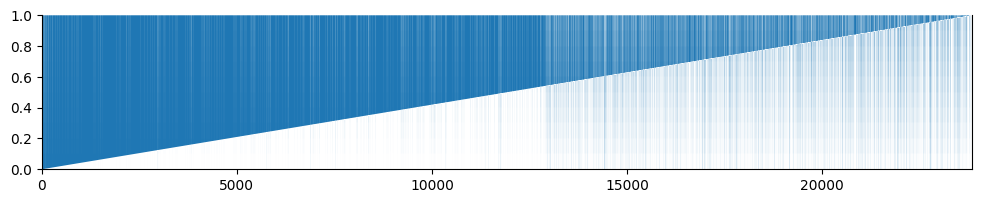

In [ ]:
fig, ax = plt.subplots(figsize=(12,2))
ax.spines['top'].set_visible(False)
plt.margins(x=0, y=0, tight=True)
#plt.axis([13000, 14000, 0, 1])
plt.fill(ys)

(10000.0, 14000.0, 0.915, 0.985)

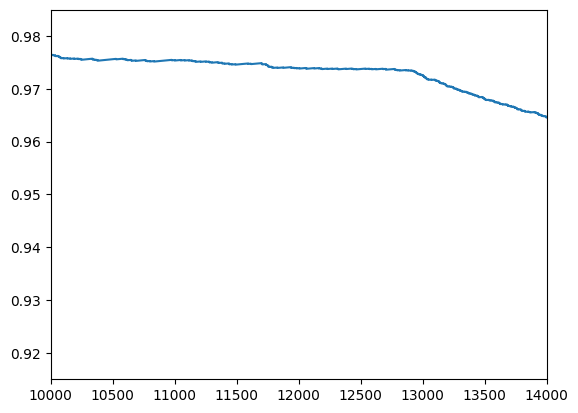

In [ ]:
plt.plot(cumulative_x, cumulative_y)
plt.axis([10000, 14000, .915, .985])

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dims, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dims, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dims)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 25)          320000    
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 50)         10200     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 50)               15200     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 24)                1224      
                                                                 
 dense_5 (Dense)             (None, 1)                 25        
                                                                 
Total params: 346,649
Trainable params: 26,649
Non-tra

In [ ]:
hist = model.fit(training_padded, training_labels, epochs=50, validation_data=(testing_padded, testing_labels))

Epoch 1/50
688/688 [==============================] - 24s 19ms/step - loss: 0.6891 - accuracy: 0.5407 - val_loss: 0.6815 - val_accuracy: 0.5952
Epoch 2/50
688/688 [==============================] - 12s 18ms/step - loss: 0.6761 - accuracy: 0.5994 - val_loss: 0.6705 - val_accuracy: 0.6146
Epoch 3/50
688/688 [==============================] - 11s 16ms/step - loss: 0.6638 - accuracy: 0.6285 - val_loss: 0.6581 - val_accuracy: 0.6443
Epoch 4/50
688/688 [==============================] - 11s 16ms/step - loss: 0.6486 - accuracy: 0.6498 - val_loss: 0.6439 - val_accuracy: 0.6513
Epoch 5/50
688/688 [==============================] - 12s 17ms/step - loss: 0.6333 - accuracy: 0.6598 - val_loss: 0.6314 - val_accuracy: 0.6579
Epoch 6/50
688/688 [==============================] - 12s 17ms/step - loss: 0.6206 - accuracy: 0.6663 - val_loss: 0.6210 - val_accuracy: 0.6653
Epoch 7/50
688/688 [==============================] - 11s 17ms/step - loss: 0.6112 - accuracy: 0.6727 - val_loss: 0.6141 - val_accuracy:

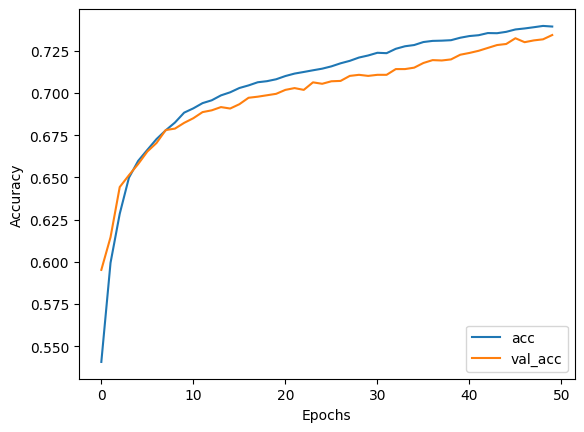

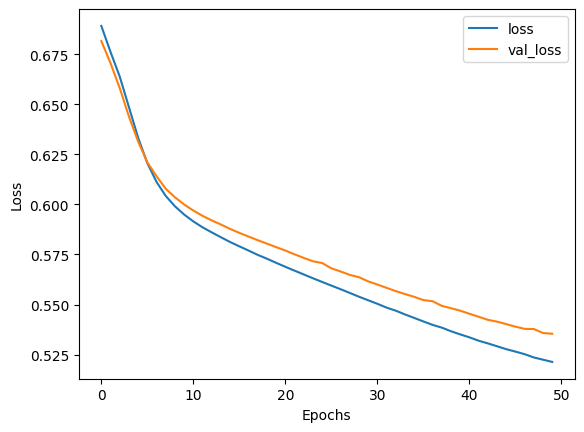

In [ ]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['acc', 'val_acc'], loc = 'lower right')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], loc = 'upper right')
plt.show()

In [ ]:
test_sentences = ["It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
                  "It's a beautiful sunny day",
                  "I lived in Ireland, so in high school they made me learn to speak and write in Gaelic",
                  "Census Foot Soldiers Swarm Neighborhoods, Kick Down Doors To Tally Household Sizes"]

In [ ]:
tokenize_test = tokenizer.texts_to_sequences(test_sentences)
padded_test = pad_sequences(tokenize_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
print(model.predict(padded_test))

1/1 [==============================] - 2s 2s/step
[[0.49758556]
 [0.13662052]
 [0.79637164]
 [0.83142626]]
